# LELEC2885 TP2 - Introduction to Wavelets

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

## 1. Introduction

In the last practical session, we implemented a first multi-resolution transform: the Laplacian Pyramid.
So far, we thus covered *three* representations of an image in total, each with its own specificities.

* The Fourier representation of an image describes it in terms of frequencies, as combinations sinusoidal patterns occurring across the whole image. Low frequencies (resp. high frequencies) tend to be associated with the smooth and large-scale shapes (resp. high-varying, small-scale oscillations). In short, the Fourier representations differentiates very effectively the content at the different scales (or frequencies) very well, but doesn't localize (spatially) this content at all. 
* On the contrary, in the spatial (or 'direct') domain, the contents of the image are perfectly well localized, but the scale information is completely absent.
* The Laplacian Pyramid―as other multiscale transforms―lies halfway between those extremes, offering a trade-off representation where each coefficient describes the content of the image at a certain localization *and* a certain scale. This makes multi-resolution analysis a powerful tool to analyze the content of an image.

The Laplacian Pyramid, however, is a *redundant* transform, in the sense that the transformed image (in this case, the pyramid, i.e. as a reminder, the different 'details' images and the lowest-resolution image) contains more coefficients than the original image.

**BONUS QUESTION (to do after the exercices):** does this mean that the Laplacian pyramid necessarily requires more memory to be stored than the initial image? *Hint: this question involves notions of image compression, that you will see in more details later in the course.*

The (discrete) wavelet transform that we will use today is such a multi-resolution transform that is not redundant, meaning that there are as many coefficients in the wavelet domain as in the initial spatial representation (with the exception, in practice, of some extra parameters sometimes introduced at the borders).

## 2. Developping intuition around wavelets

We will make heavy use of the transforms from the PyWavelets library. Let us import it along with the other libraries we will need. IPywidgets will also be useful in order to have some interactive cells.

In [ ]:
# Install dependencies
!python3 -m pip install -q PyWavelets matplotlib imageio numpy ipywidgets

In [ ]:
# And import the modules we will rely on in this session
from matplotlib import pyplot as plt
import numpy as np
import imageio
import pywt
import ipywidgets
from TP2_utils import pad, plot_wavelet, WaveletCoeffs

The library website can be found here: [https://pywavelets.readthedocs.io/en/latest/](https://pywavelets.readthedocs.io/en/latest/).
An overview of the supported wavelets is also available at [http://wavelets.pybytes.com/](http://wavelets.pybytes.com/).

In this session, we will only use the Discrete Wavelet Transform, for which there exists a fast algorithm (the fast wavelet transform for 1-D signals of size $N$ is $\mathcal O(N)$!), and that is non-redundant.
According to the [API reference](https://pywavelets.readthedocs.io/en/latest/ref/index.html), the functions we are interested in are:
* `pywt.dwt2` (resp. `pywt.idwt2`) for a *single-level* transform (resp. single-level inverse transform), and
* `pywt.wavedec2` (resp. `pywt.waverec2`) to perform a *multi-level* decomposition (resp. multi-level reconstruction).

**Remarks:**
- Those functions work on 2D signals (images), as indicated by the `2` at the end of their names. The respective functions for 1D signals are obtained simply by removing the "2" suffix.
- The single-level transform corresponds to transforming to just one resolution lower (i.e., one `level` or scale of the pyramid). In practice, when we say ''wavelet tranform of a signal'' we always refer to the multi-level transform. 


There is a wide variety of wavelets designed for specific purposes. Most of the time, a whole family of wavelets is designed at once, as is the case with Daubechies Wavelets (one of the most popular wavelet families, introduced by the the Belgian mathematician Ingrid Daubechies).

The wavelets within a family generally differ with respect to their support and smoothness. Run the following code to visualize the scaling and ("mother") wavelet functions of some usual wavelet transforms.

**Question:** Explain, in your own words, the difference between the scaling function and the wavelet function. *Hint: think back about the Laplacian pyramid... what is the targeted representation and what do we actually encode?*

In [ ]:
names = ["db1", "db2", "db3", "db5", "db18"]
plt.figure(figsize=(12,4.5))
for i, name in enumerate(names):
    scale, wavelet, x_values = pywt.Wavelet(name).wavefun()
    
    plt.subplot(2,5,i+1, title=name)
    if i == 0: plt.ylabel("Wavelet functions $\psi$")
    plt.plot(x_values, wavelet)
    
    plt.subplot(2,5,5+(i+1))
    if i == 0: plt.ylabel("Scaling functions $\phi$")
    plt.plot(x_values, scale)
    

plt.tight_layout()
plt.show()

Remark: the `db1` wavelet is the same as the classical Haar wavelet.


**Question:** At the course, we have seen that the wavelets, scaling functions, as well as downscaled version of them (of powers of 2) are *orthogonal*. Can you verify it numerically for *db4* ? Explain in your own words why the orthogonality makes sense, using geometric intuition. *Hint: recall that the wavelet transform is constructed as successive projections on spaces of lower resolution.*

In [ ]:
wavelet = pywt.Wavelet("db4")
# Get the wavelet at two different resolutions
scaling0, wavelet0, x_values0 = wavelet.wavefun(level=8)
wavelet1 = wavelet.wavefun(level=7)[1]

# For the smaller one, generate it both preceding and preceded by zeros
wavelet11 = pad(wavelet1*2, x_values0.shape[0], pos="left")
wavelet12 = pad(wavelet1*2, x_values0.shape[0], pos="right")

print("Here are the signals in question.")
plt.figure(figsize=(10,5))
plt.plot(x_values0, scaling0)
plt.plot(x_values0, wavelet0)
plt.plot(x_values0, wavelet11)
plt.plot(x_values0, wavelet12)
plt.legend(['$\phi_{0,0}$','$\psi_{0,0}$','$\psi_{1,0}$','$\psi_{1,1}$'],fontsize=15)
plt.show()

print("Are they orthogonal ?")

def are_orthogonal(s1, s2):
    """This function should return whether s1 and s2 are orthogonal, in the sense of
    https://en.wikipedia.org/wiki/Orthogonality#Orthogonal_functions
    """
    must_be_zero = ...  # YOUR IMPLEMENTATION
    return np.abs(must_be_zero) < 1e-8  # Some margin to allow for numerical error


# Throw an assertion error if any of the following signals are not orthogonal
assert are_orthogonal(scaling0, wavelet0),  "scaling0 and wavelet0 should be orthogonal"
assert are_orthogonal(scaling0, wavelet11), "scaling0 and wavelet11 should be orthogonal"
assert are_orthogonal(scaling0, wavelet12), "scaling0 and wavelet12 should be orthogonal"
assert are_orthogonal(wavelet0, wavelet11), "wavelet0 and wavelet11 should be orthogonal"
assert are_orthogonal(wavelet0, wavelet12), "wavelet0 and wavelet12 should be orthogonal"
assert not are_orthogonal(np.array([1, 1]), np.array([1, 1])),  "[1,1] and [1,1] should not be orthogonal"
print("The tests passed, it is plausible !")

You may then want to verify it for more wavelets.

**Question:** Let us consider the scaling function and the wavelet functions at different scales. How do you think each will occupy the frequency spectrum ? *Hint: think about the uncertainty principle as well as the relation between scale and frequency.*

We will use the FFT to visualize it. We can consider our wavelet has a support of 7 time units at its greater scale (as a side note, we consider db4 and db*X* has a support of $2X-1$ time units). 1 hertz (Hz) is the frequency associated with one pulse / time unit. Because we have 1793 samples for 7 time units, we can measure frequencies up to $\frac{1793}{2\cdot 7} \approx 128 \mathit{Hz}$. We will however truncate our frequency axis to the first $14 \mathit{Hz}$.

In [ ]:
duration = x_values0[-1]            # The duration of the signal, in time units
signal_length = x_values0.shape[0]  # The length of the signal (number of samples)
freq_cutoff = 14                    # Truncate frequencies at 14 Hz
cutoff = int(freq_cutoff*duration)  # The cutoff to apply in terms of sample numbers
freqs = np.arange(signal_length//2)[:cutoff] / duration
        

curves = {
    "\phi_{0,0}": wavelet.wavefun(level=8)[0]*1,
    "\psi_{0,0}": wavelet.wavefun(level=8)[1]*1,
    "\psi_{1,0}": wavelet.wavefun(level=7)[1]*2,
    "\psi_{2,0}": wavelet.wavefun(level=6)[1]*4,
    "\psi_{3,0}": wavelet.wavefun(level=5)[1]*8,
}

for name, curve in curves.items():
    curve = pad(curve, signal_length)
    plt.figure(figsize=(10,4))
    plt.subplot(121, title="${}$ in the temporal domain".format(name))
    plt.xlabel("Time (time units)")
    plt.plot(x_values0, curve)
    plt.subplot(122, title="${}$ in the Fourier domain (amplitude)".format(name))
    plt.plot(freqs, np.abs(np.fft.fft(curve)[:cutoff])/256)
    plt.xlabel("Frequency (Hz)")
    plt.show()

Do you observe the uncertainty principle in action ?

This may help you to appreciate even better the [Wikipedia page about the Wavelet transform](https://en.wikipedia.org/wiki/Wavelet_transform#Principle). Don't hesitate to read more about it.

## 3. Exercices

Now that we have some intuition about wavelets properties, we are going to play with the transforms of images.

To compute the transform of an image, people usually use the `pywt.wavedec2` function. However, given the multi-resolution nature of wavelets, the function returns the transform in the following manner:

> [cAn, (cHn, cVn, cDn), ... (cH1, cV1, cD1)] : list
> 
>     Coefficients list.  For user-specified `axes`, `cH*`
>     corresponds to ``axes[0]`` while `cV*` corresponds to ``axes[1]``.
>     The first element returned is the approximation coefficients for the
>     nth level of decomposition.  Remaining elements are tuples of detail
>     coefficients in descending order of decomposition level.
>     (i.e. `cH1` are the horizontal detail coefficients at the first level)

This means that it returns a list whose first element is the approximation, and the next elements are tuples containing the details over different axes at different scales each. The first details in the list will be the most coarse ones.

Because this kind of data structure is cumbersome to manipulate, we provide a `WaveletCoeffs` class. This class can be instantiated from the result of `pywt.wavedec2` and provides more convenient ways to access approximation and details of the signal in the wavelet coefficients domain.

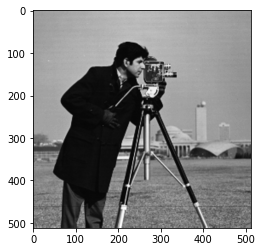

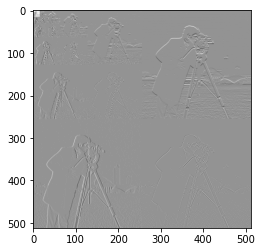

(16, 16) : approximation in pywt_format is a 2D array
(256,) : approximation in our format is a 1-D array


In [ ]:
# Load an image
img = imageio.imread("images/cameraman.png") / 255.
plt.imshow(img, cmap="gray")
plt.show()

# Compute wavelet coefficients
coeffs_pywt_format = pywt.wavedec2(img, "haar", level=5)

from TP2_utils import WaveletCoeffs
# Turn them into an object that is convenient to manipulate
base_coeffs = WaveletCoeffs(pywt.wavedec2(img, "haar", level=5))
# Plot the wavelets coefficients
plot_wavelet(base_coeffs)
plt.show()

# Create a copy we can modify
coeffs = base_coeffs.clone()

print(coeffs_pywt_format[0].shape, ": approximation in pywt_format is a 2D array")
print(coeffs.approx.shape, ": approximation in our format is a 1-D array")

A 1-D array is convenient to work with as we can merge any number of completely different arrays in it and process them at the same time. For instance, we can process all the details of one level at once.

In [ ]:
# Let us increase every coefficient of the coarsest details by 1
coeffs.details(0)[:] += 1

# PLEASE NOTE THE [:] nececssary to tell Python to replace the coefficients in-place
# (otherwise he will simply complain)

And even process details from different levels at once.

In [ ]:
# Let us cancel the coefficient from the 3 finest levels (2, 3, 4)
coeffs.details(2,4)[:] = 0

In [ ]:
# Let us observe the difference in the wavelet coefficient domain
plt.figure(figsize=(10,4))

plt.subplot(121, title="base coefficients")
plot_wavelet(base_coeffs)

plt.subplot(122, title="modified coefficients")
plot_wavelet(coeffs)

plt.show()

In [ ]:
# Finally, we can reconstruct an image from coeffs.pywt_format to reorganize
# the modified coefficients into the format expected by pywt.waverec2

plt.figure(figsize=(10,4))
plt.subplot(121, title="base coefficients")
plt.imshow(pywt.waverec2(base_coeffs.pywt_format, "haar"), cmap="gray")
plt.subplot(122, title="modified coefficients")
plt.imshow(pywt.waverec2(coeffs.pywt_format, "haar"), cmap="gray")
plt.show()

**Question:** Can you explain the artifacts you observe from the operators we have applied in the wavelet domain ?

Here is a quick summary of the different features of our `WaveletCoeffs` class:

In [ ]:
# Let us select 
print("image shape", img.shape)
print("approximation:", coeffs.approx.shape, "coeffs")
print("all details:", coeffs.details().shape, "coeffs")
print("    across", coeffs.detail_levels, "levels of details")

coeffs.approx           # approximation (as 1-D vector)
coeffs.details(0)       # first level of details (as 1-D vector)
coeffs.details(1)       # second level of details (as 1-D vector)
coeffs.details(2, ...)  # from level 2 to last (as 1-D vector)
coeffs.coeffs           # all the coefficients (approximation + details, as 1-D vector)

coeffs.pywt_format      # get the results in the same way as output of pywt.wavedec2
None

For even more convenience, we will use the `WaveletCoeffs.dec2` function with the same parameters. This way, some extra parameters can be remembered to perform the reconstruction that can be achieved through `my_coeffs.rec2()` rather than `pywt.waverec2(my_coeffs.pywt_format, "haar")` for instance.

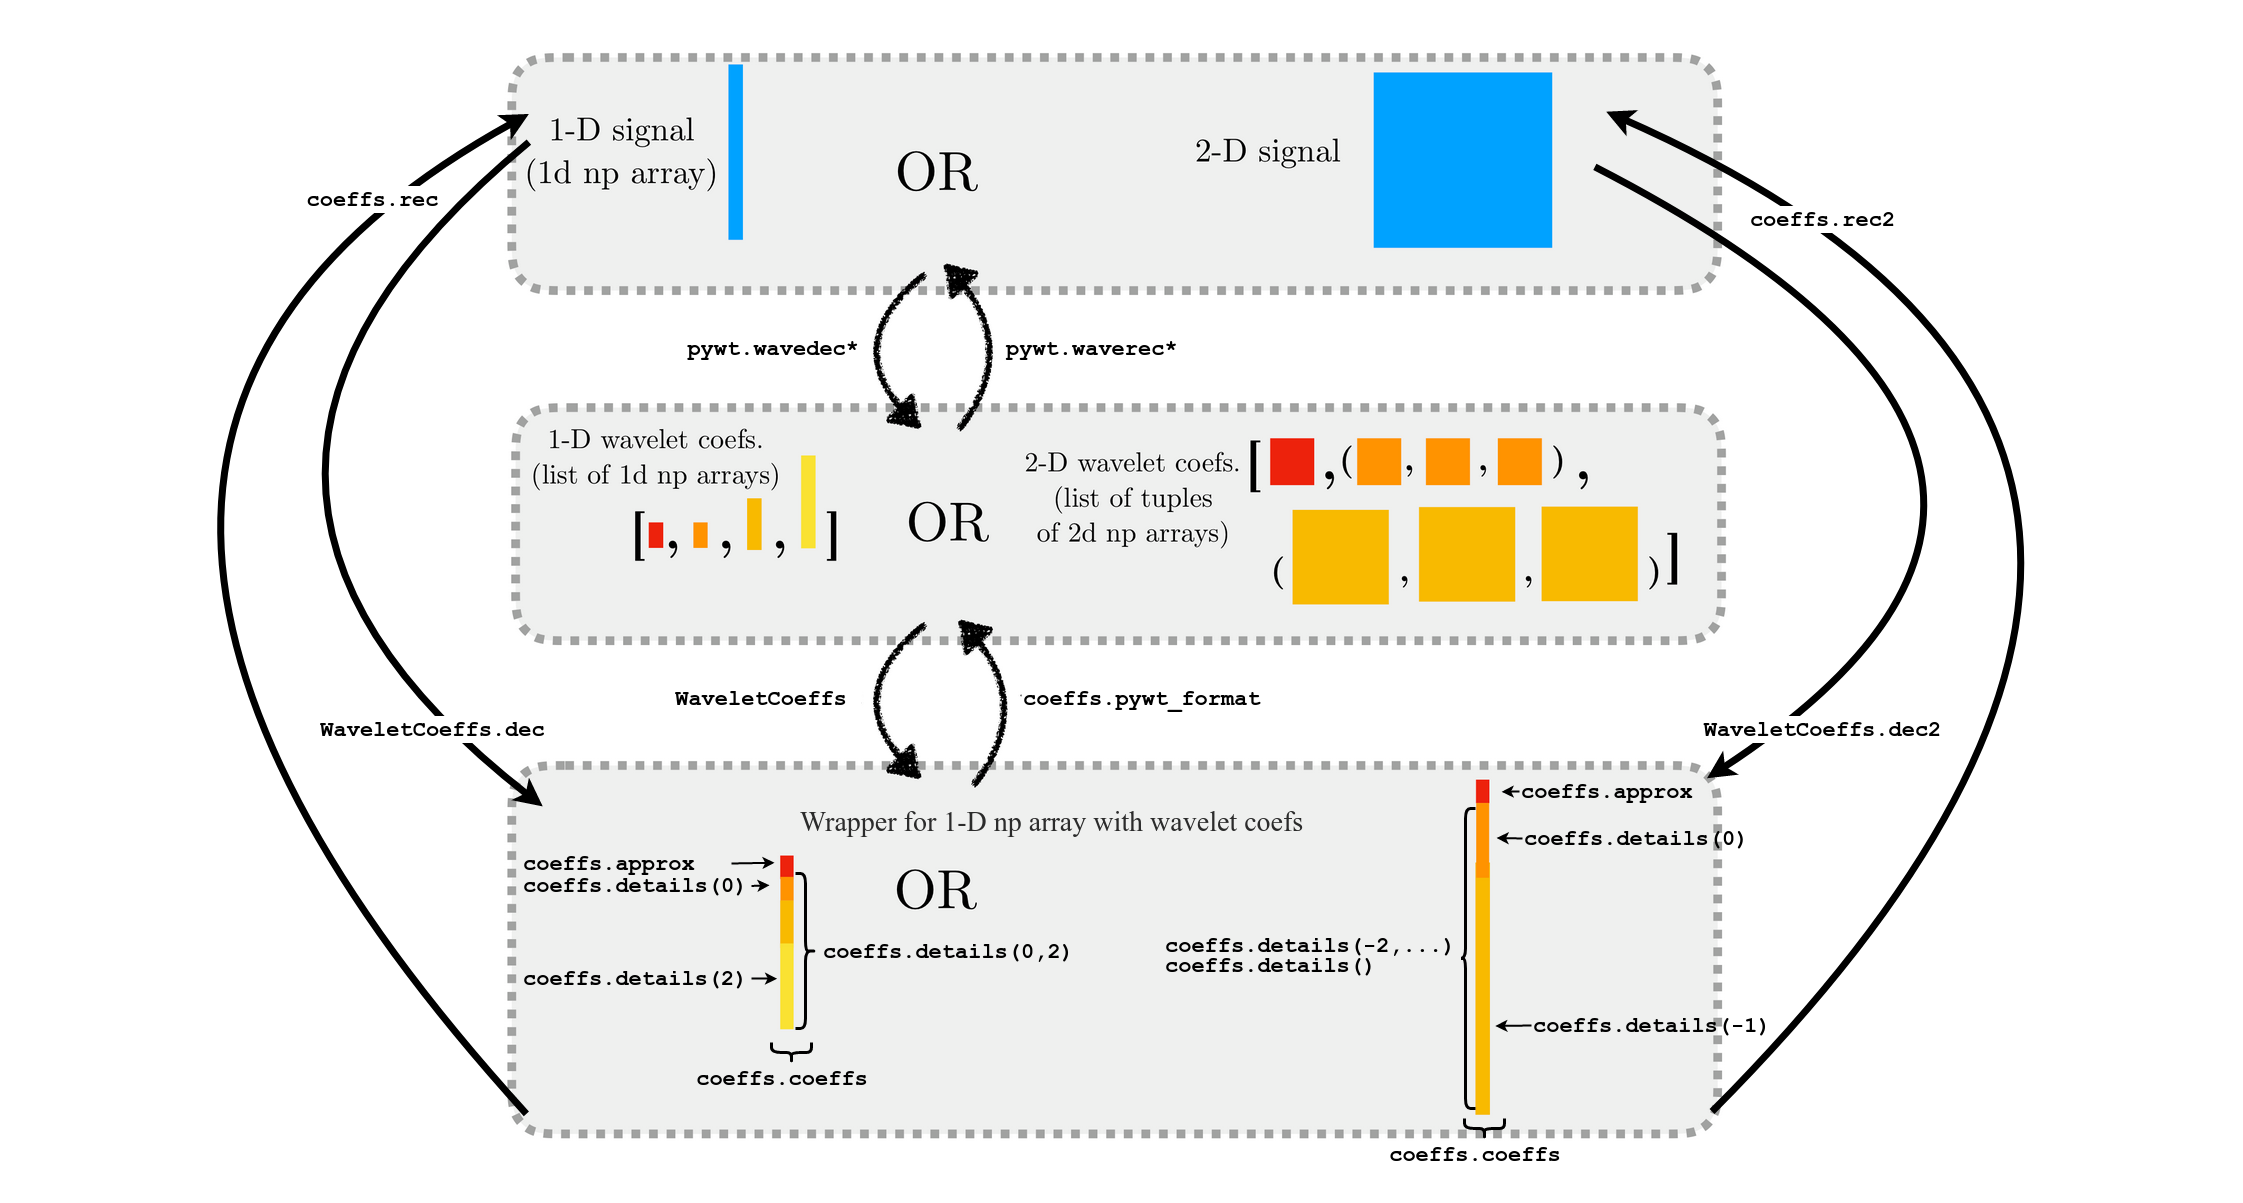

### 3.1 Coefficient distributions in different representations

Let us come back to the unmodified image.

We are interested in the distribution of the values that the wavelet coefficients take. Can you plot an histogram of the amplitude of the coefficients in both the spatial and wavelet coefficient domains ? (for *db3*, down to the 2nd level for instance)

We will use `plt.hist` that expects a one-dimensional vector as parameter, which you have to generate.

In [ ]:
coeffs = WaveletCoeffs.dec2(img, "db3", level=2)

spatial_coefficients = ...  # TODO: get pixel intensities of img as a single 1-D vector
wavelet_coefficients = ...  # TODO: get wavelet coefficients as a single 1-D vector

coeff_max = max(spatial_coefficients.max(),wavelet_coefficients.max())
bins = np.linspace(0,coeff_max,120) # To better compare both visually, use the same bins

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(np.abs(spatial_coefficients), bins=bins)  # amplitude makes it easier to compare both
plt.title('Distribution')
plt.ylabel('Spatial\nNumber of coefficients')
plt.subplot(122)
plt.hist(np.abs(spatial_coefficients), bins=bins, cumulative=True, density=True)
plt.title('Cumulative distribution')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(np.abs(wavelet_coefficients), bins=bins)
plt.ylabel('Wavelet\nNumber of coefficients')
plt.xlabel('Coefficient absolute value')
plt.subplot(122)
plt.hist(np.abs(wavelet_coefficients), bins=bins, cumulative=True, density=True)
plt.xlabel('Coefficient absolute value')
plt.show()

As you should observe above, many of the wavelet coefficients are very close to zero. This is true for many natural signals when we use a well-chosen basis: when expressed in the wavelet basis, those signals can be well expressed (or approximated) by only a few non-zero coefficents. We say that the given signal is *sparse* (or *compressible*) in that particular basis. We will now view some applications of the sparse nature of most signals.

## 3.2 Compression
It is possible to use the sparsity of signals to construct a basic image compression scheme, that is, transform the representation of the image (*encoding*) such that the encoded representation uses less memory. We should be able to reconstruct the original image from this compressed encoding without errors (lossless compression) or without a too large error (lossy compression).

To compress an image $I$, our (lossy) compression scheme will work as follows:
* Compression phase $I \rightarrow \alpha$
    1. Perform the wavelet transform of $I$
    1. Keep only the proportion $p$ of wavelet coefficient with the largest amplitude, and put the others to zero. Those thresholded coefficients $\alpha$ are our encoded image. [1]
* Reconstruction $\alpha \rightarrow \hat{I}$
    1. Perform the inverse wavelet transform of $\alpha$.
    
As you already know how to compute the wavelet coefficients and reconstruct the image back, we thus ask you to write step 2 of the compression.


[1] *Remark: For now, we suppose that there is no memory cost required to encode zero coefficients. We will go slightly further in the compression aspect in the next practical session. Finally, a more exhaustive theory of image compression will be covered later in the course.*

In [ ]:
def threshold(array, percentile=70):
    # Threshold to zero the input array, such that we zero a proportion of its elements given by percentile (in %)
    # (you may want to use np.sort on its result and then threshold every array on some value you obtain from it)
    # Please mind the fact that very negative values are as important as very positive ones.
    
    # IMPLEMENT YOUR CODE HERE
    
    return array

Let's perform a sanity check. Complete the following code, using answer to the previous questions.

In [ ]:
p_test = 90
coeffs = WaveletCoeffs.dec2(img, "db3", level=2)
thresholded_coeffs = threshold(coeffs.coeffs, percentile=p_test)
proportion_of_zeros_after_threshold = ... # TO COMPLETE

print('Threshold function with percentile = {}, gives in practice a fraction {:0.5f} of zero coefficients.'
      .format(p_test,proportion_of_zeros_after_threshold))

To evaluate the quality degradation induced by our compression quantitatively, we need an objective *metric*. We may measure the Mean Square Error (MSE) between the original image $I$ (in all generality here, of height/width $h$/$w$) and the reconstruction $\hat{I}$. A lower MSE would mean a better reconstruction.

$$
\mathit{MSE} = \frac{1}{hw}\sum_{y=0}^{h-1}\sum_{x=0}^{w-1}[I(y,x)-\hat{I}(y,x)]^2
$$

The MSE is not sensible to the actual amplitude of the signal (i.e., it measures an *absoute error*), e.g., if we scale the image and its reconstruction by any arbitrary number, we can get any value for the MSE with the same encoding strategy. The Peak Signal to Noise Ratio (PSNR) is a way to measure the error *relative to the intensity of the initial image*; it can be computed from the MSE and $\mathit{MAX}_I$, the highest possible value for our signal:

$$
\mathit{PSNR} = 10\cdot \log_{10}\left(\frac{\mathit{MAX}_I^2}{\mathit{MSE}}\right).
$$

Note that the PSNR is expressed in decibels ($dB$). Do not confuse it with the SNR, that replaces the squared maximum intensity in the initial image by the energy of this image (average squared intensity).

In [ ]:
def PSNR(truth, approximation):
    # IMPLEMENT YOUR CODE HERE

Run the following cell to try out the compression scheme with a wide range of parameters.

In [ ]:
@ipywidgets.interact(
    wavelet=["haar", "db3", "db7", "db18"],
    kept_portion=ipywidgets.FloatLogSlider(min=-4,max=2,step=1),
    keep_approx=[False, True]
)
def visualize(wavelet, kept_portion, keep_approx):
    base_coeffs = WaveletCoeffs.dec2(img, wavelet)
    coeffs = base_coeffs.clone()
    if keep_approx:
        coeffs.coeffs[:] = threshold(coeffs.coeffs, percentile=100-kept_portion)
    else:
        coeffs.details()[:] = threshold(coeffs.details(), percentile=100-kept_portion)
    reconstruction = coeffs.rec2()
    
    plt.figure(figsize=(15,5))
    plt.subplot(131, title="Wavelet coefficients")
    plot_wavelet(base_coeffs)
    plt.subplot(132, title="Thresholded coefficients")
    plot_wavelet(coeffs)
    plt.subplot(133, title="Reconstruction")
    plt.imshow(reconstruction, cmap="gray")
    plt.show()
    
    print("PSNR (dB) : \t\t\t\t", PSNR(img, reconstruction))
    print("Parameters in the approximation : \t", coeffs.approx.size)
    print("Parameters in the details : \t\t", coeffs.details().size)
    print("Kept parameters : \t\t\t", (coeffs.coeffs!=0).sum())

### 3.3 Denoising using thresholding

One can also use a wavelet basis to perform denoising.

We will consider noisy images that are obtained by adding a some Gaussian white noise with distribution $W_{y,x} \sim\mathcal{N}(0,\si^2)$ all over a captured image. The key assumption here is that the image is sparse in the wavelet domain, but the noise is not (this is a simple consequence of the noise being *white*).

Denoising will thus consist in recovering an estimation of the real image $I_0$ from the noisy image $I = I_0 + W\in \mathbb R^{wh}$ given some prior on its original structure (sparse in a given wavelet basis) and the noise that has affected it (the noise is not sparse in that basis).

In [ ]:
I0 = img                                            # the original image
sigma = 0.08
I = I0 + np.random.normal(0, sigma, size=I0.shape)  # the amplitude of the noise

plt.figure(figsize=(10,5))
plt.subplot(121, title="Natural image")
plt.imshow(I0, cmap="gray")
plt.subplot(122, title="Noisy image")
plt.imshow(I, cmap="gray")
plt.show()
print("PSNR", PSNR(I0, I))

We now ask you to write a function that will kill off (put to zero) the smallest wavelet coefficients, i.e. the ones that are likely mainly due to noise. The mathematical operation that we will perform on the wavelet coefficents is called **Hard Thresholding** and is defined as follows:

$$
s_T^0(\al) = \choice{
    \al \qifq \abs{\al}>T, \\
    0 \quad\text{otherwise}.
}
$$

Note that this is different from the thresholding we did above, where we kept a *fixed* number of coefficients, here we keep all the coefficients that lie above some threshold $T$.

In [ ]:
def thresh_hard(u,T):
    """Hard threshold u with threshold T
    """
    # YOUR IMPLEMENTATION

base_coeffs = WaveletCoeffs.dec2(I, "haar")
coeffs = base_coeffs.clone()

T = sigma*3
coeffs.coeffs[:] = thresh_hard(coeffs.coeffs, T)
rec = coeffs.rec2()

plt.figure(figsize=(15,5))
plt.subplot(131, title="Wavelet coefficients")
plot_wavelet(base_coeffs)
plt.subplot(132, title="Thresholded coefficients")
plot_wavelet(coeffs)
plt.subplot(133, title="Reconstruction")
plt.imshow(rec, cmap="gray")
plt.show()
print("PSNR", PSNR(I0, rec))

When relying on those type of deblurring methods, a crucial parameter to fix is the threshold $T$. Try out some different values in the cell above, then run the following cell which computes the PSNR of the denoised image as a function of the threshold $T$. 

**Question:** What do you observe? How can we select $T$ in practice? To go even further, we recommend to change the test image and/or the noise level: what is the influence on the choice of $T$?

In [ ]:
base_coeffs = WaveletCoeffs.dec2(I, "haar")
nb_T_toTest = 101
T_toTest = np.linspace(0,3,nb_T_toTest)
PSNRs_hardth = np.zeros(nb_T_toTest)


for (iT,T) in enumerate(T_toTest):
    coeffs = base_coeffs.clone()
    coeffs.coeffs[:] = thresh_hard(coeffs.coeffs,T)
    rec = coeffs.rec2()
    PSNRs_hardth[iT] = PSNR(I0, rec)

plt.figure(figsize=(12,5))
plt.plot(T_toTest,PSNRs_hardth)
plt.plot(T_toTest,PSNRs_hardth[0]*np.ones(nb_T_toTest),'k:')
plt.legend(['PSNR denoised image','PSNR noisy image'])
plt.xlabel('Threshold T')
plt.ylabel('PSNR after denoising')
plt.show()

## 4. Reducing artifacts

In the last exercise, using hard thresholding for denoising, you should be able to observe blocky artifacts due to the nature of the haar wavelets. We propose here different methods to try to mitigate the problem.

We encourage you to try to implement some of these and interpret your results to confirm/infirm our hypothesis. You may justify your opinion on both metrics and visual results.

### 4.1 Soft Thresholding

The hard thresholding operator introduces discontinuity, which may contribute to those artifacts. The soft-thresholding operator avoids the discontinuity with the following formula :

$$
s_T^1(\al) = \choice{
    \al-T \qifq \al>T, \\
    \al+T \qifq \al<T, \\
    0 \quad\text{otherwise}.
}
$$

**Question:** Implement the deblurring scheme defined above, but with the soft-thresholding operator instead of the hard-thresholding. Compare the methods. Try different values of $T$ for both methods.

Remark: the $^1$ refers to the fact that soft thresholding the wavelet coefficients can be seen as a form of to penalizing the $\ell_1$ norm of $\alpha$ (that encourages the sparsity in the wavelet domain). More precisely, when we denoise $I$ as follows ($\Psi$ and $\Psi^*$ denote the forward and inverse wavelet transform)

$$
    \hat{I} = \Psi^* s_T^1(\Psi I),
$$

we are actually solving the optimization problem
$$
    \hat{I} = \min_{I'} \frac{1}{2}\|I - I'\|_2^2 + T \|\Psi I'\|_1.
$$
This helps to see the mathematical influence of the parameter $T$ in this case (in fact, it can be used to derive the optimal value of $T$ as a function of $\sigma$, which we won't do here).

<img src='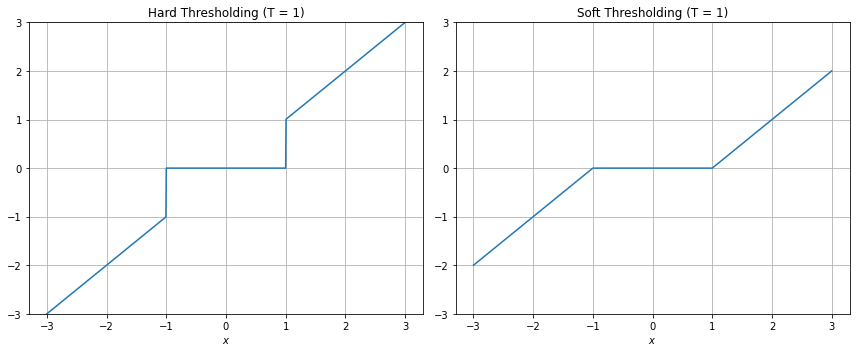
' />

In [ ]:
T = sigma*3
def thresh_soft(u,T):
    """Soft threshold u with threshold T
    """
    # YOUR IMPLEMENTATION

base_coeffs = WaveletCoeffs.dec2(I, "haar")
coeffs = base_coeffs.clone()
coeffs.coeffs[:] = thresh_soft(coeffs.coeffs, T)
rec = coeffs.rec2()

plt.figure(figsize=(15,5))
plt.subplot(131, title="Wavelet coefficients")
plot_wavelet(base_coeffs)
plt.subplot(132, title="Thresholded coefficients")
plot_wavelet(coeffs)
plt.subplot(133, title="Reconstruction")
plt.imshow(rec, cmap="gray")
plt.show()
print("PSNR", PSNR(I0, rec))

Now, let's compare both hard and soft thresholding denoising for different threshold values $T$. 

**Question:** Comment on the graph below. What are the advantages/disadvantages of using one thresholding function over the other? What happens for other images and noise levels?

In [ ]:
base_coeffs = WaveletCoeffs.dec2(I, "haar")
nb_T_toTest = 101
T_toTest = np.linspace(0,3,nb_T_toTest)
PSNRs_hardth = np.zeros(nb_T_toTest)
PSNRs_softth = np.zeros(nb_T_toTest)


for (iT,T) in enumerate(T_toTest):
    coeffs = base_coeffs.clone()
    coeffs.coeffs[:] = thresh_hard(coeffs.coeffs,T)
    rec_hard = coeffs.rec2()
    PSNRs_hardth[iT] = PSNR(I0, rec_hard)
    
    coeffs = base_coeffs.clone()
    coeffs.coeffs[:] = thresh_soft(coeffs.coeffs,T)
    rec_soft = coeffs.rec2()
    PSNRs_softth[iT] = PSNR(I0, rec_soft)

plt.figure(figsize=(12,5))
plt.plot(T_toTest,PSNRs_hardth)
plt.plot(T_toTest,PSNRs_softth)
plt.plot(T_toTest,PSNRs_hardth[0]*np.ones(nb_T_toTest),'k:')
plt.legend(['PSNR denoised image hard thresholding','PSNR denoised image soft thresholding','PSNR noisy image'])
plt.xlabel('Threshold T')
plt.ylabel('PSNR after denoising')
plt.show()

### 4.2 Other wavelet basis

The haar wavelet is blocky by nature. Changing for a smoother wavelet basis could mitigate that problem. (e.g. $\mathit{db}x \text{ with } x \in [2,20]$).

In [ ]:
T = sigma*3

wavelet = ...
base_coeffs = WaveletCoeffs.dec2(I, wavelet)
coeffs = base_coeffs.clone()
coeffs.coeffs[:] = thresh_hard(coeffs.coeffs,T)
rec = coeffs.rec2()

plt.figure(figsize=(15,5))
plt.subplot(131, title="Wavelet coefficients")
plot_wavelet(base_coeffs)
plt.subplot(132, title="Thresholded coefficients")
plot_wavelet(coeffs)
plt.subplot(133, title="Reconstruction")
plt.imshow(rec, cmap="gray")
plt.show()
print("PSNR", PSNR(I0, rec))

This is beyond the scope of this practical session, but note that wavelets are, by their construction, focusing on details that are aligned with the horizontal/vertical axes in the image. Other \*-lets (curvelets, shearlets) try to compensate this limitation.

### 4.3 Thresholding coefficients from *detailed* scales only

The blocky artifacts are mostly disturbing when they occur at large scale. Furthermore, we could hypothetize that on a large region, the noise is cancelled by averaging.

This leads us to propose that applying the thresholding on detailed scales only may mitigate the problem.

In [ ]:
T = sigma*3

base_coeffs = WaveletCoeffs.dec2(I, "haar")
coeffs = base_coeffs.clone()
# threshold details on 3 higher resolutions for instance?
# YOUR IMPLEMENTATION HERE
rec = coeffs.rec2()

plt.figure(figsize=(15,5))
plt.subplot(131, title="Wavelet coefficients")
plot_wavelet(base_coeffs)
plt.subplot(132, title="Thresholded coefficients")
plot_wavelet(coeffs)
plt.subplot(133, title="Reconstruction")
plt.imshow(rec, cmap="gray")
plt.show()
print("PSNR", PSNR(I0, rec))

### 4.4 Cycle spinning

The wavelet transform is not translation invariant. Can you picture yourself why and how it impacts the reconstruction ?

Cycle spinning compensates the lack of translation-invariance of the wavelet basis by averaging the reconstructions obtained with translations of the wavelet basis. In practice, it can simply be achieved by performing the translations on the image before decoding and inverting them after reconstruction.

Let us consider $N^2$ translations, `(0,0)`, `(0,1)`, `(1,0)`, `(1,1)`, ..., `(N-1,N-2)`, `(N-1,N-1)`. For each shifted image, we will perform the wavelet decomposition, the thresholding, the reconstruction, and shift it again to realign it with the source image. This process leaves us with $N^2$ reconstructions $R_{ij}$.

One can then compute the final reconstruction $$R = \frac{1}{N^2}\sum_{(i,j)\in [0,N)^2}R_{ij}$$.

In [ ]:
import itertools

T = sigma*3
N = 10

reconstructions = []
for i, j in itertools.product(range(N), range(N)):
    I_ij = ...
    coeffs = WaveletCoeffs.dec2(I_ij, "haar")
    coeffs.coeffs[:] = thresh_hard(coeffs.coeffs,T)
    rec_ij = ...
    
    reconstructions.append(rec_ij)

rec = ...

plt.figure(figsize=(15,5))
plt.subplot(131, title="Wavelet coefficients")
plot_wavelet(coeffs)
plt.subplot(133, title="Reconstruction")
plt.imshow(rec, cmap="gray")
plt.show()
print("PSNR", PSNR(I0, rec))

**Question**: Is there an optimal $N$ ?

**Question:** Now you are more familiar with wavelets, can you describe similarities and differences with the Laplacian Pyramid ?

### More resources
Don't hesitate to check out the [Numerical Tours](http://www.numerical-tours.com/python/) where many applications of wavelets are covered. The Matlab version of the tour is even more extensive, good to know if you need examples on some specific problem.